In [64]:
input_model = "bert"

In [65]:
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [28]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

In [30]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [31]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 800

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 512

# Max embeddings in BERT
BERT_MAX_EMBEDDINGS = 1024

# fraction of data to use for training
FRACTION = 1

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [32]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.25.2
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.0.3
sklearn version: 1.2.2


In [33]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [34]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = f'{BASE_PATH}/Reddit/both_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/both_test.csv'
rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)


# Split data into test and train
train_size = int(0.8 * len(rdt_train))
X_train = rdt_train[0:train_size].post
X_val = rdt_train[train_size:].post
X_test = rdt_test.post
y_train = rdt_train[0:train_size].class_id
y_val = rdt_train[train_size:].class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [35]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['adhd' 'anxiety' 'bipolar' 'depression' 'ptsd' 'none']


array([0, 1, 2, 3, 4, 5])

In [36]:
rdt_train

,ID,title,post,class_name,class_id
0,c83a3338-d43f-43ac-a5cd-032049ea0214,i am ready to see a professional. but i'm scar...,"ever since i was little, i’ve always thought s...",adhd,0
1,0baebc43-64f0-4c4a-8d1b-8c8e343051ae,i feel great about a situation that just happe...,i had a friend post on facebook about mental h...,anxiety,1
2,20225455-8b07-4e24-9408-843d2e3640b3,"when in doubt, shake it out.","i swear, i used to think this was the stupides...",anxiety,1
3,623b4a8b-67e0-4d85-a787-a677770a3959,i'm scared,"i'm 14 years old, diagnosed at 13. i'm scared ...",bipolar,2
4,f42a1427-7795-4d57-a116-b1c4373c7eda,"""i liked you better when you weren't depressed...","dylan, my old best friend. about half a year a...",depression,3
...,...,...,...,...,...
13722,dec9adb7-27c7-4228-b67e-7e147ac7308e,bipolar without medication,why are there so few studies and articles abou...,bipolar,2
13723,25e08d68-994e-44cb-a859-bc8e5e16ba82,try pushing out your stomach when you're feeli...,we all know how important the gut is with anxi...,anxiety,1
13724,2f05f92a-21b2-4726-86ee-9eb88f564d32,i missed so many classes already and i’m terri...,i don’t know why i feel so irrationally. i hav...,anxiety,1
13725,1d9df54b-e458-4b71-a268-0f51eea0c3bf,i created a chatbot to help people with anxiet...,it’s a digital coach that helps in difficult m...,ptsd,4


In [37]:
test_examples[30]

"whenever i'm awake for too long, i get anxiety, even though i have nothing to feel anxious about. like,if i need to stay awake for studying or work in, or, for example,let's say i stayed up all night, and then i want to stay awake during the day to fix my internal clock; (so i won't sleep during the day and stay awake dud push my body when needed like a normal person. this always happens when i push myself to stay awake and is really annoying, and also, other people don't understand or trust me and end up seeing me as just undisciplined and unable to have self control (just sleeping because i give in too easily or idk). tl;dr: post title"

In [38]:
test_labels[30]

1

In [39]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (10981,)
Validation set labels shape: (2746,)
Test set labels shape: (1488,)
Training set examples shape: (10981,)
Validation set examples shape: (2746,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


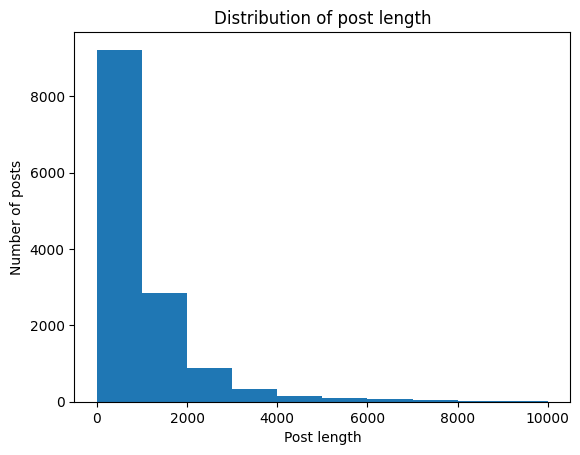

In [40]:
#@ Histogram of all post length
plt.hist(rdt_train["post"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [41]:
rdt_train

,ID,title,post,class_name,class_id
0,c83a3338-d43f-43ac-a5cd-032049ea0214,i am ready to see a professional. but i'm scar...,"ever since i was little, i’ve always thought s...",adhd,0
1,0baebc43-64f0-4c4a-8d1b-8c8e343051ae,i feel great about a situation that just happe...,i had a friend post on facebook about mental h...,anxiety,1
2,20225455-8b07-4e24-9408-843d2e3640b3,"when in doubt, shake it out.","i swear, i used to think this was the stupides...",anxiety,1
3,623b4a8b-67e0-4d85-a787-a677770a3959,i'm scared,"i'm 14 years old, diagnosed at 13. i'm scared ...",bipolar,2
4,f42a1427-7795-4d57-a116-b1c4373c7eda,"""i liked you better when you weren't depressed...","dylan, my old best friend. about half a year a...",depression,3
...,...,...,...,...,...
13722,dec9adb7-27c7-4228-b67e-7e147ac7308e,bipolar without medication,why are there so few studies and articles abou...,bipolar,2
13723,25e08d68-994e-44cb-a859-bc8e5e16ba82,try pushing out your stomach when you're feeli...,we all know how important the gut is with anxi...,anxiety,1
13724,2f05f92a-21b2-4726-86ee-9eb88f564d32,i missed so many classes already and i’m terri...,i don’t know why i feel so irrationally. i hav...,anxiety,1
13725,1d9df54b-e458-4b71-a268-0f51eea0c3bf,i created a chatbot to help people with anxiet...,it’s a digital coach that helps in difficult m...,ptsd,4


In [42]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 1956/10981 (0.17812585374738185)
Labels 1 in training set: 1949/10981 (0.17748838903560696)
Labels 2 in training set: 1905/10981 (0.17348146799016484)
Labels 3 in training set: 1970/10981 (0.1794007831709316)
Labels 4 in training set: 1598/10981 (0.14552408705946634)
Labels 0 in validation set: 509/2746 (0.185360524399126)
Labels 1 in validation set: 473/2746 (0.1722505462490896)
Labels 2 in validation set: 502/2746 (0.18281136198106337)
Labels 3 in validation set: 480/2746 (0.17479970866715222)
Labels 4 in validation set: 403/2746 (0.14675892206846322)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [43]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{0: 'adhd', 1: 'anxiety', 2: 'bipolar', 3: 'depression', 4: 'ptsd', 5: 'none'}
{'adhd': 0, 'anxiety': 1, 'bipolar': 2, 'depression': 3, 'ptsd': 4, 'none': 5}


In [44]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [45]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [46]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [47]:

#@title Train BERT model using CLS token
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    #bert_out = bert_base_model(bert_inputs)
    bert_out = bert_base_model.bert([input_ids, attention_mask, token_type_ids])


    # The first token of every example is a CLS token
    cls_embedding = bert_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


def bert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train BERT model
    """
    # Load BERT model
    config_l = BertConfig.from_pretrained("bert-base-cased")
    config_l.num_max_position_embeddingslabels = BERT_MAX_EMBEDDINGS
    bert_model = TFBertModel.from_pretrained('bert-base-cased', config = config_l)

    # Load training, validation and test data
    train_samples = train[0:int(fraction*len(train))]
    val_samples = val[0:int(fraction*len(val))]

    # Tokenize training, validation and test data
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    bert_train_inputs, bert_val_inputs = tokenize_train_val(bert_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    bert_train_labels = np.array(tlabels)
    bert_train_sample_labels = bert_train_labels[0:int(fraction*len(tlabels))]

    bert_val_labels = np.array(vlabels)
    bert_val_sample_labels = bert_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    bert_avg_model = create_bert_cls_model(bert_model, hidden_size=HIDDEN_LAYER_SIZE)

    bert_avg_model.summary()

    bert_avg_model_history = bert_avg_model.fit(
        bert_train_inputs,
        bert_train_sample_labels,
        validation_data=(bert_val_inputs, bert_val_sample_labels),
        batch_size=12,
        epochs=2)

    return bert_avg_model, bert_avg_model_history

In [48]:
fraction = 1
model, model_history = bert_main(train_examples, val_examples, train_labels, val_labels, fraction)

(None, 768)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 800)]                0         []                            
 r)                                                                                               
                                                                                                  
 attention_mask_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 800)]                0         []                            
 tLayer)                                                                        

916/916 [==============================] - 571s 581ms/step - loss: 0.8158 - accuracy: 0.7173 - val_loss: 0.6243 - val_accuracy: 0.7917
Epoch 2/2
916/916 [==============================] - 529s 577ms/step - loss: 0.5165 - accuracy: 0.8295 - val_loss: 0.6936 - val_accuracy: 0.7713


In [49]:
# Save the model
path = f'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/{input_model}'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)
print(f'Saving model to {path}')
tf.keras.models.save_model(model, path)

Saving model to drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/bert


In [50]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
test_tokens = tokenize_test(bert_tokenizer, test_examples)
y_prediction = model.predict(test_tokens)

47/47 [==============================] - 23s 433ms/step


In [54]:
y_prediction

array([[5.6234567e-06, 3.1530869e-04, 8.7187938e-05, 1.3766595e-04,
        9.9945074e-01, 3.4049003e-06],
       [2.0322886e-03, 9.8808843e-01, 1.9170170e-03, 6.5787677e-03,
        1.1816473e-03, 2.0174598e-04],
       [2.7614049e-04, 2.2509726e-02, 4.8786593e-03, 6.5490324e-03,
        9.6550256e-01, 2.8380429e-04],
       ...,
       [1.3260511e-03, 9.9620336e-01, 8.0561714e-04, 8.9193421e-04,
        6.3068169e-04, 1.4241728e-04],
       [1.0314973e-01, 2.9589954e-01, 3.4368224e-02, 5.5134898e-01,
        1.2350868e-02, 2.8826066e-03],
       [8.2579575e-04, 6.4228574e-04, 9.9763668e-01, 2.8227808e-04,
        5.8732968e-04, 2.5660282e-05]], dtype=float32)

In [52]:
# Convert predicted probabilities to class labels
y_pred_label = np.argmax(y_prediction, axis=1) # Convert probabilities to discrete class labels

In [53]:
y_pred_label

array([4, 1, 4, ..., 1, 3, 2])

	 Printing confusion matrix


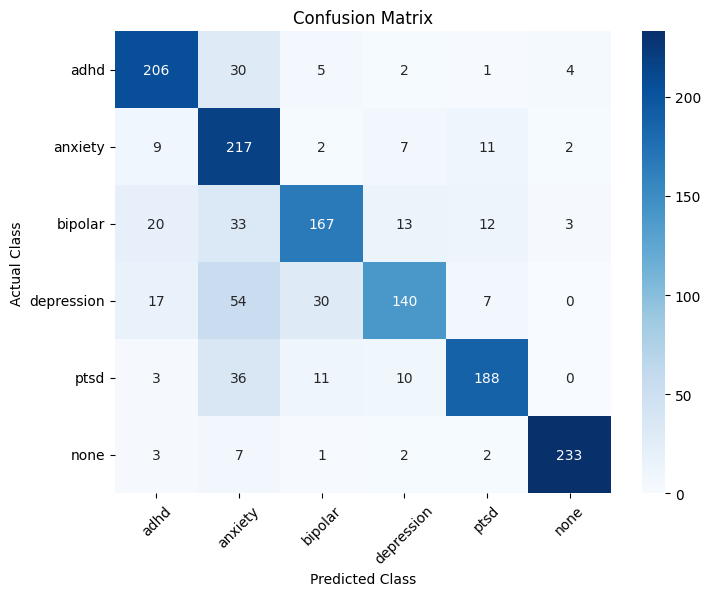

Accuracy: 0.7735215053763441
              precision    recall  f1-score   support

        adhd       0.80      0.83      0.81       248
     anxiety       0.58      0.88      0.69       248
     bipolar       0.77      0.67      0.72       248
  depression       0.80      0.56      0.66       248
        ptsd       0.85      0.76      0.80       248
        none       0.96      0.94      0.95       248

    accuracy                           0.77      1488
   macro avg       0.79      0.77      0.77      1488
weighted avg       0.79      0.77      0.77      1488



In [59]:
from sklearn.metrics import confusion_matrix
print('\t Printing confusion matrix')
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test_labels, y_pred_label)

# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

# Add labels, title, and color bar
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, y_pred_label)}')

print(classification_report(test_labels, y_pred_label, target_names=predictions_names))

In [67]:
print('\t Saving all mismatches')
# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

mismatches = []
for i in range(len(test_labels)):
    if test_labels[i] != y_pred_label[i]:
        id1 = test_labels[i]
        id2 = y_pred_label[i]
        entry = {}
        entry['actual'] = actuals_names[id1]
        entry['predicted'] = predictions_names[id2]
        entry['test_id'] = i
        entry['text'] = test_examples[i]
        mismatches.append(entry)
df = pd.DataFrame(mismatches)
df.to_csv('drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/mismatches_bert.csv', index=False)


	 Saving all mismatches
